Saving namib.jpg to namib (2).jpg


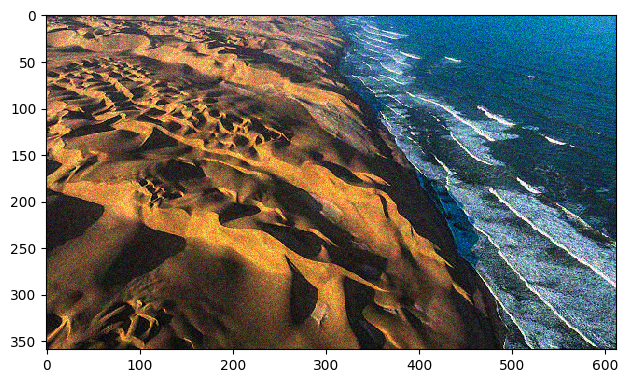

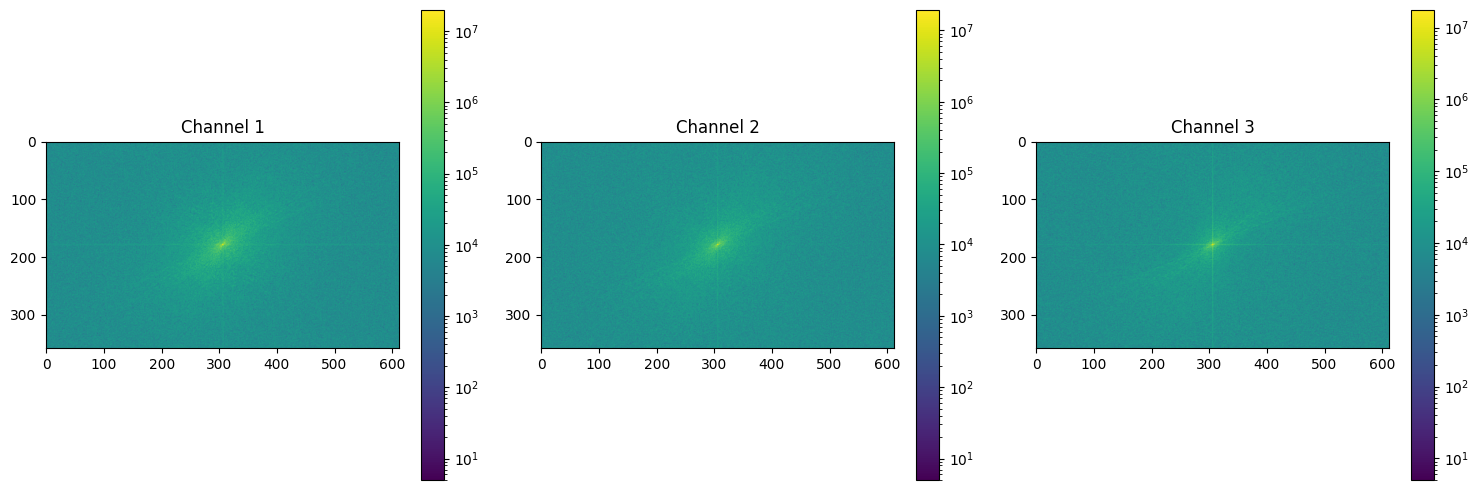

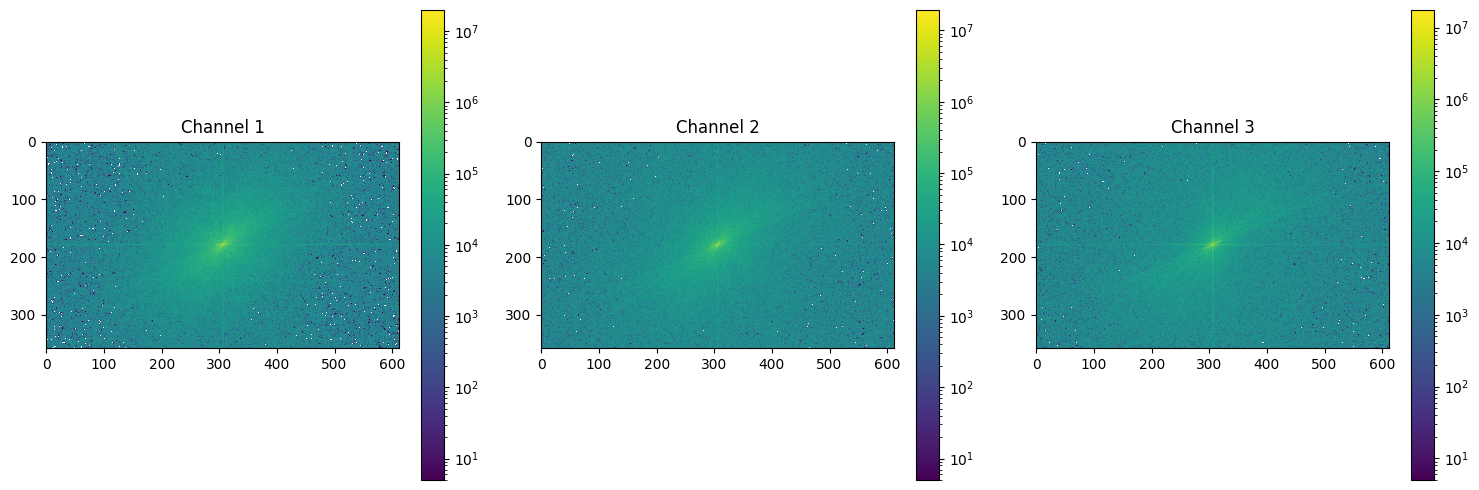

In [10]:
import numpy as np
from skimage import io
import cv2
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fft2, fftshift
from scipy import fftpack
from PIL import Image
import pywt
from google.colab import files
from google.colab.patches import cv2_imshow

uploaded = files.upload()
image_path = next(iter(uploaded))
image = io.imread(image_path)

def poissoning(image, lambda_value=64):
    noisy_image = np.zeros_like(image, dtype=np.float64)
    for i in range(image.shape[2]):
        noisy_channel = np.random.poisson(image[:, :, i] / 255.0 * lambda_value) / lambda_value * 255.0
        noisy_image[:, :, i] = np.clip(noisy_channel, 0, 255)
    noisy_image = noisy_image.astype(np.uint8)
    return noisy_image

noised_image = poissoning(image, 64)
io.imshow(noised_image)

def display_TF(image):
    abs_val = np.abs(image)
    plt.figure(figsize=(15, 5))
    for i in range(image.shape[2]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(fftshift(abs_val[:, :, i]), norm=LogNorm(vmin=5))
        plt.title(f"Channel {i + 1}")
        plt.colorbar()
    plt.tight_layout()

img_Fourier = np.fft.fft2(noised_image, axes=(0, 1))
display_TF(img_Fourier)

def adaptive_filter(channel, threshold_factor=0.2):
    mean_amp = np.mean(np.abs(channel))
    std_amp = np.std(np.abs(channel))
    threshold = threshold_factor * std_amp
    channel[np.abs(channel) < threshold] = 0
    return channel

def denoising(image, threshold_factor=0.2):
    denoised_img = np.zeros_like(image, dtype=np.complex128)
    for i in range(image.shape[2]):
        denoised_img[:, :, i] = adaptive_filter(image[:, :, i], threshold_factor)
    return denoised_img

denoised_image_TF = denoising(img_Fourier, threshold_factor=0.2)
display_TF(denoised_image_TF)

denoised_image = np.fft.ifft2(denoised_image_TF, axes=(0, 1)).real

denoised_image_normalized = np.zeros_like(denoised_image, dtype=np.float64)
for i in range(denoised_image.shape[2]):
    denoised_image_normalized[:, :, i] = (denoised_image[:, :, i] - np.min(denoised_image[:, :, i])) / (np.max(denoised_image[:, :, i]) - np.min(denoised_image[:, :, i])) * 255
